In [1]:
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pylab import *
from skimage import data
from skimage.viewer.canvastools import RectangleTool
from skimage.viewer import ImageViewer
from tqdm import tqdm
import torch
import torch.nn as nn  
import torch.optim as optim 
import torchvision.transforms as transforms 
import torch.nn.functional as F
import torchvision
import pandas as pd
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 
from PIL import Image
import math
import json

/Users/aneesh/opt/anaconda3/envs/LTTS/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: viewer requires Qt
  
/Users/aneesh/opt/anaconda3/envs/LTTS/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if os.path.exists("../mmocr") == False:
    print("MMOCR not installed. Please run BASH script first")

In [3]:
print(torch.__version__)

1.12.0


Load PyTorch Model and helpers


In [4]:
class FCN(nn.Module):
    def __init__(self,in_channels = 1,num_classes=7):
        super(FCN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(64, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(64, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(20736,256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(256)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(128)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(64)
        )
        self.fc4 = nn.Linear(64,7)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(x.shape[0],-1)
        # print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = F.softmax(self.fc4(x),dim=1)
        return x

In [5]:
model_location = input("Enter model location: ")
# /content/drive/MyDrive/LTTS Internship/model_Inverted
model = FCN()
x = torch.randn(64,1,150,150)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Setting model up on",device)
if torch.cuda.is_available() == True:
    model.cuda()
    model.load_state_dict(torch.load(model_location))

else:
    my_model = model.load_state_dict(torch.load(model_location, map_location=torch.device('cpu')))

data_transform = transforms.Compose([
                                    transforms.Lambda(lambda x:torch.from_numpy(np.expand_dims(np.array(x),axis=0)).float())
                                ])

model.eval() 
print("Model ready")

Enter model location: ./model_Inverted
Setting model up on cpu
Model ready


Load and Display a P&ID Sheet


Enter P&ID image file: ./3.jpg


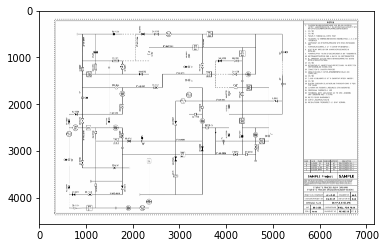

In [6]:
read_location = input('Enter P&ID image file: ')
img = cv2.imread(read_location,0)
plt.imshow(img,cmap='gray')
plt.show()

Get ROI from image
1. Roughly estimate the x range and y range for a valid diagram (try to exclude unecessary regions like the entire text area on the side to avoid wasting time)
2. For the above x = 400 to 5600 roughly and y = 250 to 5000 roughly

In [7]:
x_start = int(input("x start: "))
x_end = int(input("x_end: "))
y_start = int(input("y_start: "))
y_end = int(input("y_end: "))

x start: 400
x_end: 5600
y_start: 250
y_end: 5000


Image to work on:


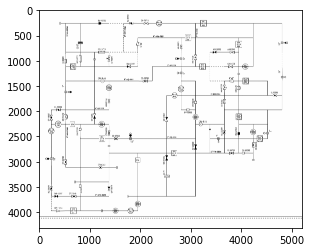

In [8]:
ready_img = img[y_start:y_end,x_start:x_end]
print("Image to work on:")
plt.imshow(ready_img,cmap='gray')
plt.show()

Re-Color image into black and white

In [9]:
def recolor_crop(crop):
    for i in tqdm(range(len(crop))):
        for j in range(len(crop[0])):
            if crop[i][j] >=120:
                crop[i][j] = 225
            else:
                crop[i][j]=0

    return crop

In [10]:
colorized = recolor_crop(ready_img)

100%|███████████████████████████████████████████████████████████████████| 4311/4311 [01:00<00:00, 71.11it/s]


In [11]:
main_img = colorized.copy()

In [12]:
def invert(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if x[i][j] > 200:
                x[i][j] = 0
            else:
                x[i][j] = 1
    return x

Loop to traverse the sheet and obtain regions with information present

In [13]:
m,n = img.shape

In [14]:
objects_info = {}
object_id = 0
'''
format:
    oject_info[1] : {
        class_id: int
        bounding_box = [xmin,xmax,ymin,ymax]
    }
'''

for i in tqdm(range(0,m-150,75)):
    for j in range(0,n-150,75):
        x_min = j
        x_max = j+150
        y_min = i
        y_max = i+150

        bounding_box = [x_min,x_max,y_min,y_max]
        
        xmid = x_min + ((x_max-x_min)//2)
        ymid = y_min + ((y_max-y_min)//2)

        centroid = [xmid,ymid]

        temp = main_img[y_min:y_max,x_min:x_max]
        window = temp.copy()

        black = np.count_nonzero(window == 0)
        total = 150 * 150

        percentage_black = (black/total)*100

        if percentage_black>10:
            window = invert(window)
            im_pil = Image.fromarray(window)
            im = data_transform(im_pil)
            im_a = im.numpy()
            im_a = np.expand_dims(im_a, axis=0)
            t = torch.tensor(im_a)
            with torch.no_grad():  
                t = t.to(device)   
                score = model(t)

                _, predictions = torch.max(score, 1)

                class_id = predictions.item()
                if class_id != 6:

                    temp_dict = {
                        "class_id":int(class_id),
                        "bounding_box":bounding_box,
                        "centroid":centroid
                    }

                    objects_info[object_id] = temp_dict
                    object_id+=1






100%|███████████████████████████████████████████████████████████████████████| 59/59 [00:16<00:00,  3.68it/s]


In [15]:
def get_distance(x,y):
    xmid1 = x[0]
    ymid1 = x[1]

    xmid2 = y[0]
    ymid2 = y[1]

    return math.sqrt((ymid2-ymid1)**2 + (xmid2-xmid1)**2)



Group bounding boxes

In [16]:
list_of_objects = list(objects_info.keys())
groups = []

for i in range(len(objects_info)):
    curr_object = objects_info[list_of_objects[i]]
    curr_centroid = curr_object['centroid']
    curr_class = curr_object['class_id']

    temp_grp = [i]

    for j in range(len(objects_info)):
        compare_object = objects_info[list_of_objects[j]]
        compare_centroid = compare_object['centroid']
        compare_class = compare_object['class_id']

        #Group using centroid and class preds

        if get_distance(curr_centroid,compare_centroid) < 80 and curr_class == compare_class:
            temp_grp.append(j)

    temp_grp.sort()

    groups.append(temp_grp)

groups_dict = {}
been_done = {}

for i in groups:
    temp = i

    if temp[0] not in been_done.keys():
        been_done[temp[0]] = temp[0]

    main_key = been_done[temp[0]]

    if main_key not in groups_dict.keys():
        groups_dict[main_key] = []

    for j in temp:
        been_done[j] = main_key


    groups_dict[main_key].extend(temp)


    groups_dict[main_key] = list(set(groups_dict[main_key]))
    groups_dict[main_key].sort()


In [17]:
final_info = {}

draw_img = colorized.copy()
for i in groups_dict.keys():
    object_id = i

    x_min_list = []
    y_min_list = []
    x_max_list = []
    y_max_list = []

    for j in groups_dict[i]:

        xmin,xmax,ymin,ymax = objects_info[j]['bounding_box']

        x_min_list.append(xmin)
        x_max_list.append(xmax)
        y_min_list.append(ymin)
        y_max_list.append(ymax)

    xmin = min(x_min_list)
    ymin = min(y_min_list)
    xmax = max(x_max_list)
    ymax = max(y_max_list)

    xmid = xmin + ((xmax-xmin)//2)
    ymid = ymin + ((ymax-ymin)//2)

    xmin = xmid-80
    ymin = ymid-80
    xmax = xmid+80
    ymax = ymid+80



    class_id = objects_info[i]['class_id']

    temp = {}
    temp = {
        "class_id":class_id,
        "bbox": [xmin,xmax,ymin,ymax],
        "centroid": [xmid,ymid]
    }

    draw_img = cv2.rectangle(draw_img, (xmin,ymin), (xmax,ymax), (0,225,0), 5)

    final_info[i] = temp





Group similar BBOXES and take only region of max area

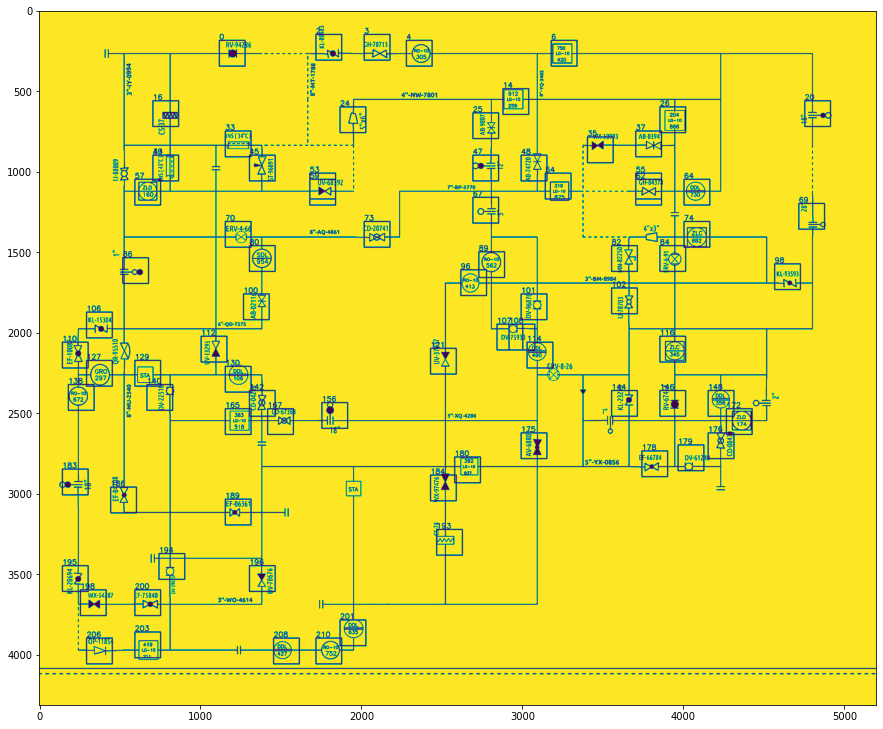

In [18]:
modif_info = final_info.copy()
for i in list(modif_info.keys()):

    if i not in modif_info.keys():
        continue

    curr_object = modif_info[i]
    x_min,x_max,y_min,y_max = curr_object['bbox']
    curr_class = curr_object['class_id']

    curr_centroid = curr_object['centroid']

    temp = main_img[y_min:y_max,x_min:x_max]
    window = temp.copy()

    black = np.count_nonzero(window == 0)
    total = 150 * 150

    curr_percentage_black = (black/total)*100

    for j in list(modif_info.keys()):
        
        if j not in modif_info.keys():
            continue

        if i!=j:
            compare_object = modif_info[j]
            x_min,x_max,y_min,y_max = compare_object['bbox']
            compare_class = compare_object['class_id']

            compare_centroid = compare_object['centroid']

            distance = get_distance(curr_centroid,compare_centroid)
            # print(distance)

            if distance < 150:

                temp = main_img[y_min:y_max,x_min:x_max]
                window = temp.copy()

                black = np.count_nonzero(window == 0)
                total = 150 * 150

                compare_percentage_black = (black/total)*100

                if compare_percentage_black + 1 <= curr_percentage_black:
                    
                    del modif_info[j]

draw_img = colorized.copy()

for i in modif_info.keys():
    obj = modif_info[i]

    xmin,xmax,ymin,ymax = obj['bbox']

    draw_img = cv2.rectangle(draw_img, (xmin,ymin), (xmax,ymax), (0,225,0), 5)
    cv2.putText(draw_img, str(i), (xmin, ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,225,0), 3)


plt.figure(figsize=(15,30))
plt.imshow(draw_img)
plt.show()

In [19]:
cv2.imwrite("./FINAL_P&ID.jpg",draw_img)

True

Text Processing

MMOCR

In [20]:
%cd ..

/Users/aneesh/Desktop/LTTS_Code


In [21]:
%cd ./mmocr/

/Users/aneesh/Desktop/LTTS_Code/mmocr


In [22]:
from mmocr.utils.ocr import MMOCR

In [23]:
ocr = MMOCR(det='PS_CTW', recog='SAR')

load checkpoint from http path: https://download.openmmlab.com/mmocr/textdet/psenet/psenet_r50_fpnf_600e_ctw1500_20210401-216fed50.pth


/Users/aneesh/Desktop/LTTS_Code/mmocr/mmocr/apis/inference.py:50: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


load checkpoint from http path: https://download.openmmlab.com/mmocr/textrecog/sar/sar_r31_parallel_decoder_academic-dba3a4a3.pth


/Users/aneesh/Desktop/LTTS_Code/mmocr/mmocr/apis/inference.py:50: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [24]:
!pip install imutils

In [25]:
from imutils.object_detection import non_max_suppression

In [32]:
def east_detect(image):
    texts = ["None"]
    layerNames = [
    	"feature_fusion/Conv_7/Sigmoid",
    	"feature_fusion/concat_3"]
    
    image = np.pad(image, ((30,30),(30,30)),"constant", constant_values=(225,225))

    orig = image.copy()
    
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    (H, W) = image.shape[:2]

    (newW, newH) = (160, 160)
    
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    
    (H, W) = image.shape[:2]
    
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    	(123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    start = time.time()
    
    net.setInput(blob)
    
    (scores, geometry) = net.forward(layerNames)
    
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
    
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
                        
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    if len(boxes) > 0:  
      text_list = []
      for (startX, startY, endX, endY) in boxes:
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        if startX-20 > 0:
          startX = startX-20
        if endX+20 < orig.shape[1]:
          endX = endX+20
        if startY-10 > 0:
          startY = startY-10
        if endY+10 < orig.shape[0]:
          endY = endY+10

        crop = orig[startY:endY, startX:endX]

        # plt.imshow(crop)
        # plt.show()

        if (endX - startX) < (endY - startY):
          crop = cv2.rotate(crop, cv2.ROTATE_90_CLOCKWISE)
          crop = np.pad(crop, ((20,20),(20,20)),"constant", constant_values=(225,225))

          region = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
          cv2.imwrite('temp.jpg',region)

          results = ocr.readtext('temp.jpg',print_result=False)

          temp_dict = results[0]
          texts = temp_dict['text']

          break

        else:
          crop = np.pad(crop, ((20,20),(20,20)),"constant", constant_values=(225,225))
          region = cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)

          cv2.imwrite('temp.jpg',orig)

          results = ocr.readtext('temp.jpg',print_result=False)

          temp_dict = results[0]
          texts = temp_dict['text']
          break

    return texts

In [33]:
final_dict = {}
counter = 0

text_img = colorized.copy()
for i in modif_info.keys():

    temp_dict = {}

    obj = modif_info[i]
    class_id = obj['class_id']
    xmin,xmax,ymin,ymax = obj["bbox"]

    temp_dict['bounding_box'] = [xmin,xmax,ymin,ymax]
    temp_dict['text'] = []
    temp_dict['class_id'] = class_id
    temp_dict['centroid'] = obj['centroid']

    xmin,xmax,ymin,ymax = xmin-20,xmax+20,ymin-20,ymax+20

    t = text_img[ymin:ymax,xmin:xmax]

    if class_id == 3:


        temp_dict['text'] = ["Spectacle blind"]

    elif class_id == 5:

        region = cv2.cvtColor(t,cv2.COLOR_GRAY2RGB)
        
        cv2.imwrite('temp.jpg',region)

        results = ocr.readtext('temp.jpg',print_result=False)

        temp_dict['text'] = results[0]['text']


    else:
        xmin,xmax,ymin,ymax = xmin-20,xmax+20,ymin-20,ymax+20

        r = text_img[ymin:ymax,xmin:xmax]
        text = east_detect(r)

        temp_dict['text'] = text


    final_dict[i] = temp_dict
    counter+=1


In [34]:
final_temp = final_dict.copy()
for i in list(final_temp.keys()):

    if i not in final_temp.keys():
        continue

    curr_object = final_temp[i]
    curr_centroid = curr_object['centroid']

    for j in list(final_temp.keys()):
        
        if j not in final_temp.keys():
            continue

        if i!=j:
            compare_object = final_temp[j]
            compare_centroid = compare_object['centroid']

            distance = get_distance(curr_centroid,compare_centroid)

            if distance < 50:
                del final_temp[j]


Post Processing of Outputs

In [35]:
def getAlphabetCount(x):
    counter = 0

    for i in x:
        if i.isalpha() == True:
            counter+=1
    return counter

In [36]:
out_dict = {}

for i in final_temp.keys():

    obj = final_temp[i]
    class_id = obj['class_id']
    text_list = obj['text']

    

    item_label = "Undefined" # text ID of component
    component_name = "Undefined" #Valve, instrument

    if class_id == 0:
        component_name = "Valve"
        if text_list[0] != "None":

            for j in text_list:

                count = getAlphabetCount(j)

                if len(j)>2 and count<4:
                    item_label = j.upper()
                    break
                

    if class_id == 1:
        component_name = "Control Valve"
        item_label = "CV"
        if text_list[0] != "None":

            for j in text_list:

                count = getAlphabetCount(j)

                if len(j)>2 and count<4:
                    item_label = j.upper()
                    break

    if class_id == 2:
        component_name = "Circular looking"

        if text_list[0] != "None":

            for j in text_list:

                count = getAlphabetCount(j)

                if len(j)>2 and count<4:
                    item_label = j.upper()
                    break

    
    if class_id == 3:
        component_name = "Spectacle Blind"

        if text_list[0] != "None":

            for j in text_list:

                count = getAlphabetCount(j)

                if len(j)>2 and count<4:
                    item_label = j.upper()
                    break

    if class_id ==4:
        
        if text_list[0] != "None":
            
            search = "INS"
            for j in text_list:
                if search in j:
                    item_label = j.upper()
                    break

            if item_label == "Undefined":
                item_label = "CS"
                component_name = "Inline Mixer/Filter"

    if class_id ==5:

        component_name = "Instrument"

        if text_list[0] != None:
            
            if len(text_list) > 1:

                for x in range(len(text_list)-1):
                    curr = text_list[x]
                    next = text_list[x+1]

                    count = getAlphabetCount(curr)

                    if count>0:
                        if next.isnumeric():
                            item_label = curr+";"+next
                            break

            
    temp_dict = {}

    temp_dict['class_id'] = class_id
    temp_dict['bounding_box'] = obj['bounding_box']
    temp_dict['component_name'] = component_name
    temp_dict['item_name'] = item_label

    out_dict[i] = temp_dict


In [37]:
pd_dict = {

    "Object-ID":[],
    "Class-ID":[],
    "Component Name":[],
    "Item Label":[],
    "Location (xmin,xmax,ymin,ymax)":[]

}
for i in out_dict.keys():
    object_id = i
    class_id = out_dict[i]['class_id']
    component_name = out_dict[i]['component_name']
    item_name = out_dict[i]['item_name']
    bbox = out_dict[i]['bounding_box']
    location = "".join(str(x)+"," for x in bbox)

    pd_dict["Object-ID"].append(object_id)
    pd_dict["Class-ID"].append(class_id)
    pd_dict["Component Name"].append(component_name)
    pd_dict["Item Label"].append(item_name)
    pd_dict["Location (xmin,xmax,ymin,ymax)"].append(location)

In [46]:
%cd ..
%cd main_driver

/Users/aneesh/Desktop/LTTS_Code
/Users/aneesh/Desktop/LTTS_Code/main_driver


In [47]:
import pandas as pd

In [48]:
df = pd.DataFrame(pd_dict)  

In [49]:
df.to_excel('./FINAL_RESULT.xlsx')

In [50]:
name = os.path.basename(read_location)
name = name.split(".")[0]
folder = os.path.dirname(read_location)
folder_name = folder+"/"+name

if os.path.exists(folder+"/temp") == False:
    os.makedirs(folder+"/temp")

dst = folder+"/temp"
source1 = folder+"/FINAL_P&ID.jpg"
source2 = folder+"/FINAL_RESULT.xlsx"
shutil.copy(source1, dst)
shutil.copy(source2,dst)

shutil.make_archive(folder_name,'zip',dst)

'/Users/aneesh/Desktop/LTTS_Code/main_driver/3.zip'